# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, I used the following techniques from previous lessons:

- Color selection
- Region of interest selection
- Canny edge detection 
- Hough Transform for lane line detection

There are flags that turns some features on and off, like color selection, and averaging the lines.

---

## Import Packages

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


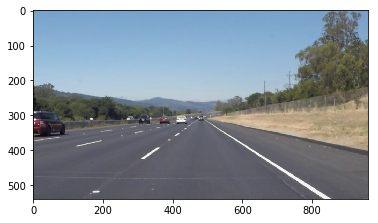

In [7]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
# New Helper functions

prev_left = []
prev_right = []

# This function takes array of lines as input
# for each line, it determine whether it belongs to 
# the left or right side based on the slope and cache that 
# in corresponding set, then average each set
#
def average_lines(lines):
    global prev_left
    global prev_right

    if lines is None:
        return prev_left, prev_right

    left = []
    right = []

    # Collect slope and intercept for left and right lines
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue  # skip vertical lines
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            if slope < 0:
                left.append((slope, intercept))
            else:
                right.append((slope, intercept))

    # Calculate the average for left and right lines
    left_avg = [sum(y) / len(y) for y in zip(*left)]
    right_avg = [sum(y) / len(y) for y in zip(*right)]

    
    # For more rebustness
    # Take the new average, and average it again with the previous average
    # 
    
    if left_avg:
        if prev_left:
            left_avg = [(prev_left[0] + left_avg[0]) / 2, (prev_left[1] + left_avg[1]) / 2]
    elif prev_left:
        left_avg = prev_left

    if right_avg:
        if prev_right:
            right_avg = [(prev_right[0] + right_avg[0]) / 2, (prev_right[1] + right_avg[1]) / 2]
    elif prev_right:
        right_avg = prev_right

    prev_right = right_avg
    prev_left = left_avg

    return left_avg, right_avg



# takes array of lines, determine left and right lines, and draw them
def draw_averaged_lines(img, lines, color=[255, 0, 0], thickness=2):
    
    global prev_left
    global prev_right

    imshape = img.shape
        
    # get the average left and average right
    left_avg, right_avg = average_lines(lines)

    # Draw left line
    y1 = int(imshape[0])
    y2 = int(imshape[0]*0.6)
    x1 = int((y1 - left_avg[1]) / left_avg[0])
    x2 = int((y2 - left_avg[1]) / left_avg[0])

    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # Draw right line
    y1 = int(imshape[0])
    y2 = int(imshape[0] * 0.6)
    x1 = int((y1 - right_avg[1]) / right_avg[0])
    x2 = int((y2 - right_avg[1]) / right_avg[0])

    cv2.line(img, (x1, y1), (x2, y2), color, thickness)




In [9]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    if lines is None:
        return
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    
    global use_average_lines
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    if use_average_lines:
        draw_averaged_lines(line_img, lines, thickness=15)
    else:
        draw_lines(line_img, lines)
    
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images


In [10]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Lane Finding Pipeline



In [11]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def pipeline(image):
    gray            = grayscale(image)
    blur            = gaussian_blur(gray, 15)
    edges           = canny(blur, low_threshold=50, high_threshold=150)

    imshape = image.shape
    vertices = np.array([[(imshape[1]* 0.1, imshape[0] * 0.95),
                          (imshape[1] * 0.4, imshape[0] * 0.6),
                          (imshape[1] * 0.6, imshape[0] * 0.6),
                          (imshape[1] * 0.9, imshape[0] * 0.95)]], dtype=np.int32)

    masked_edges    = region_of_interest(edges, vertices)
    lines           = hough_lines(masked_edges, rho=1, 
                                  theta=1*np.pi/180, 
                                  threshold=20, 
                                  min_line_len=20, 
                                  max_line_gap=20)
    lines_edges     = weighted_img(lines, image)

    result = lines_edges
    return result


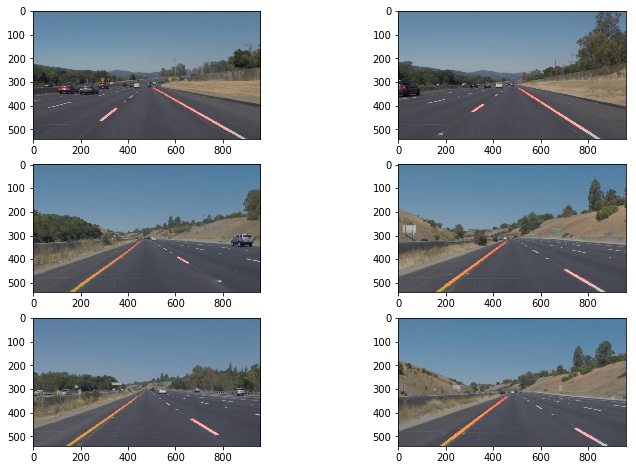

In [24]:
# This flag is used to turn on/off the color filters in the pipeline. 
# If the value is set to True, the first pipeline phase will be to select
# White and Yellow colors and mask everything else out.
filter_colors = False

# This flag will cause the hough lines function to draw averaged lines instead
# of all lines
use_average_lines = False


from os.path import splitext
import matplotlib 
i=0
plt.figure(figsize=(12, 8))
for fn in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + fn)
    line_img = pipeline(image)
    mpimg.imsave("test_images_output/" + splitext(fn)[0]+".png", line_img)
    # plot images for review
    plt.subplot(3, 2, i+1)
    plt.imshow(line_img)
    i=i+1


In [13]:
# 
# Utility method to select range of colors, tuned for White and Yellow lane colors
# based on tutorial http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
#
# The filters needs to be tuned to pick up the colors in appropriate conditions 
# for example, if there is heavy fog or snow, the choosen values may not work correctly
#
def select_target_colors(img):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower_yellow = np.array([0, 0, 180])
    upper_yellow = np.array([100, 190, 255])

    # Threshold the HSV image to get only yellow colors
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    lower_white = np.array([0, 0, 0], dtype=np.uint8)
    upper_white = np.array([20, 10, 255], dtype=np.uint8)

    # Threshold the HSV image to get only white colors
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    mask = white_mask + yellow_mask

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img, img, mask=mask)

    return res


## Test on Videos


In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    global filter_colors
    
    if filter_colors:
        startImg   = select_target_colors(image)
    else:
        startImg   = image
    
    gray            = grayscale(startImg)
    blur            = gaussian_blur(gray, 15)
    edges           = canny(blur, low_threshold=50, high_threshold=150)

    imshape = image.shape
    vertices = np.array([[(imshape[1]* 0.1, imshape[0] * 0.95),
                          (imshape[1] * 0.4, imshape[0] * 0.6),
                          (imshape[1] * 0.6, imshape[0] * 0.6),
                          (imshape[1] * 0.9, imshape[0] * 0.95)]], dtype=np.int32)

    masked_edges    = region_of_interest(edges, vertices)
    lines           = hough_lines(masked_edges, rho=1, theta=1*np.pi/180, threshold=20, min_line_len=20, max_line_gap=20)
    lines_edges     = weighted_img(lines, image)

    result = lines_edges
    return result

Let's try the one with the solid white lane on the right first ...

In [16]:

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 94.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.11 s, sys: 589 ms, total: 2.7 s
Wall time: 2.73 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

There are two flags that can turn some features on and off

- filter_colors: True will select yellow and white colors from images before doing any further processing

- use_average_lines: True will cause hough transofrmation to average and extraploate the found lines before drawing them

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [18]:
# This flag is used to turn on/off the color filters in the pipeline. 
# If the value is set to True, the first pipeline phase select
# White and Yellow colors from the image and mask everything else out.
filter_colors = True

# This flag will cause the hough lines function to draw averaged lines instead
# of all lines
use_average_lines = True

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:10<00:00, 66.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12.8 s, sys: 3.43 s, total: 16.2 s
Wall time: 10.6 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [20]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 34.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 8.66 s, sys: 1.91 s, total: 10.6 s
Wall time: 7.98 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))